# Stochastic Gradient Descent (SGD) Experiments

**Authored by Alexandre Mathias DONNAT, Sr - Télécom Paris**

## Introduction 

The purpose of this session is to implement algorithms of the stochastic gradient type (Stochastic Gradient Descent, SGD).
In a first step, in order to become familiar with SGD, we will implement the algorithm in the classical setting of binary classification.

## Definitions and notation

We recall here the supervised binary classification setting and introduce the notation used:

$Y$: the set of data labels. We consider the binary case for simplicity, so there are only two classes. It is convenient to work with $Y=\{-1,1\}$ to represent labels (we will handle signs throughout this work).

$x=(x_1,\ldots,x_p)^\top \in X \subset \mathbb{R}^p$: an observation, an example, a point (a sample). The $j$-th coordinate of $x$ is the value taken by the $j$-th variable (a feature).

$D_n=\{(x_i,y_i), \ i=1,\ldots,n\}$: a training set containing $n$ examples and their labels.

There exists a probabilistic model governing the generation of observations via random variables $X$ and $Y$: for all $i\in\{1,\ldots,n\}$, $(x_i,y_i)$ are i.i.d. samples from $(X,Y)$.

From the training set $D_n$, we aim to construct a function called a classifier, $\hat{h}:X\to\{-1,1\}$, which assigns a label $\hat{h}(x_{\text{new}})$ to a new point $x_{\text{new}}\in X$.

We measure the performance of a classifier, for a loss function $\ell:\mathbb{R}\times\mathbb{R}\to\mathbb{R}$, by the risk $\mathbb{E}[\ell(\hat{h}(X),Y)]$. In practice, this quantity cannot be computed, so we use its empirical counterpart:

$$\frac{1}{n}\sum_{i=1}^{n}\ell(\hat{h}(x_i),y_i).$$

We denote by $\frac{\partial\ell}{\partial h}$ the partial derivative of $\ell$ with respect to its first argument.

We consider the case where the family of classifiers is indexed by a parameter $w\in\mathbb{R}^p$, i.e.

$$\hat{h}_w(x)=w^\top x$$

(if we want to add an intercept term, we can for instance include an additional constant feature). One way to obtain a satisfactory $w$ is to choose the one that minimizes the empirical risk. We thus introduce

$$f_i(w)=\ell(w^\top x_i,y_i)$$

and we seek to minimize

$$\frac{1}{n}\sum_{i=1}^{n}f_i(w).$$

When $n$ is very large, it may be preferable to use, instead of gradient descent, a stochastic version described below.

**Remark:** if the algorithm returns

$$\bar{w}_T=\frac{1}{T}\sum_{t=1}^{T}w_t,$$

i.e., the average of the iterates rather than the last iterate, this is called averaged stochastic gradient descent.


### Common Tools: SGD (used for Q3–Q13)

Throughout this lab, we will use the provided `stochastic_gradient` function.
It implements SGD for the quadratic loss (Q3) and will be extended for:
- L2 regularization (Q7),
- variable step size γ(t) (Q8),
- averaging (Q10),
- hinge loss (Q12).

In [121]:
import numpy as np
import matplotlib.pyplot as plt
plt.close("all")

In [ ]:
############################################################################
#                Stochastic gradient
############################################################################

def decision_function(X, w):
    """prediction function from a weight vector"""
    return np.dot(X, w[1:]) + w[0]

def predict(X, w):
    """class prediction function from a weight vector"""
    return np.sign(decision_function(X, w))

def stochastic_gradient(X, y, gamma, n_iter, w_ini, loss="mse",
                        alpha=0.0, average=False, t0=0):
    """Stochastic gradient algorithm

    Optimizes (empirical version):
        (1/n) sum_i ell( h_w(x_i), y_i ) + (alpha/2) ||w||^2

    Notes:
    - We add a column of 1s to X to absorb the bias w0.
    - By convention here: we do not regularize the bias w0, only w[1:].
    - average=True: we also return an average of the iterates (Q10).
    """
    n_samples = X.shape[0]
    X = np.concatenate((np.ones((n_samples, 1)), X), axis=1)

    all_w = np.zeros((n_iter, w_ini.size))
    w = w_ini.copy()

    # following the objective J(w_t)
    pobj = np.zeros(n_iter)

    # Q8: gamma can be constant or a function gamma(t)
    if not callable(gamma):
        def gamma_func(t):
            return float(gamma)
    else:
        gamma_func = gamma

    # Q10: variables for averaging
    w_bar = w.copy()
    n_bar = 0  # number of iterations included in the average

    for t in range(n_iter):
        idx = np.random.randint(n_samples)
        x_i = X[idx]      # (p+1,)
        y_i = y[idx]
        h_i = np.dot(x_i, w)

        # empirical objective (for display)
        if loss == "mse":
            pobj[t] = 0.5 * np.mean((y - np.dot(X, w)) ** 2) + 0.5 * alpha * np.sum(w[1:] ** 2)
        elif loss == "hinge":
            margins = y * (np.dot(X, w))
            pobj[t] = np.mean(np.maximum(0.0, 1.0 - margins)) + 0.5 * alpha * np.sum(w[1:] ** 2)
        else:
            raise ValueError("loss must be 'mse' or 'hinge'")

        # Q3: stochastic gradient computation
        if loss == "mse":
            # ell(h,y) = 1/2 (h-y)^2  -> grad_w fi(w) = (h_i - y_i) x_i
            gradient = (h_i - y_i) * x_i

    
        # Q12: hinge loss
        # ell(h,y) = max(0, 1 - y h)
        # grad = -y x_i if y h < 1, else 0
        elif loss == "hinge":
            if y_i * h_i < 1.0:
                gradient = -y_i * x_i
            else:
                gradient = np.zeros_like(w)

        # Q7: L2 regularization
        # + (alpha/2)||w||^2  -> + alpha*w on weights (not bias)
        if alpha > 0:
            reg = np.zeros_like(w)
            reg[1:] = alpha * w[1:]
            gradient = gradient + reg

        # update SGD
        w = w - gamma_func(t) * gradient

        # Q10: averaging optional
        # w̄_{T+1} = T/(T+1) w̄_T + 1/(T+1) w_{T+1}
        # and variant: do not average before t0
        if average:
            if t >= t0:
                n_bar += 1
                w_bar = (1 - 1/n_bar) * w_bar + (1/n_bar) * w

        all_w[t] = w

    if average:
        return w, w_bar, all_w, pobj
    return w, all_w, pobj

## 1. Example with synthetic data

In this first part, we consider a linear regression problem
and study the stochastic gradient descent algorithm (SGD)
for the quadratic loss.

We will use the `stochastic_gradient` function provided in .py file given
`SGD_classification.py`, and the objective of Q1 to Q3 is to
make the explicit link between:

- the mathematical definition of the loss,
- the computation of the stochastic gradient,
- and its concrete implementation in the SGD algorithm.

### Q1 - Quadratic loss and partial derivative

We consider the quadratic loss defined by:

$$
\ell(h, y) = \frac{(h - y)^2}{2},
$$

where $h$ denotes the model's prediction and $y$ the target value.

We compute the partial derivative of the loss with respect to the prediction $h$:

$$
\frac{\partial \ell}{\partial h}(h, y) = h - y.
$$

This expression measures the prediction error and constitutes the central term of the gradient used in the descent algorithm.

### Q2 - Gradient of the elementary cost function $f_i(w)$

We consider a linear model parameterized by $w \in \mathbb{R}^p$ and an
observation $(x_i, y_i)$.
The associated prediction is:

$$
h_i(w) = w^\top x_i.
$$

We define the elementary cost function:

$$
f_i(w) = \ell(w^\top x_i, y_i).
$$

By applying the chain rule, the gradient of $f_i$ with respect
to the parameter vector $w$ is given by:

$$
\nabla f_i(w)
= \frac{\partial \ell}{\partial h}(h_i(w), y_i)\,\nabla_w (w^\top x_i)
= (w^\top x_i - y_i)\,x_i.
$$

This gradient corresponds to the **stochastic gradient**, computed from
a single observation.


### Q3 - Implementation of the stochastic gradient algorithm

We now implement the stochastic gradient descent algorithm
using the provided `stochastic_gradient` function.

The general algorithm is recalled below:

---

**Algorithm 1 : Stochastic Gradient**

---
**Input:** observations and their labels $D_n = \{(x_i, y_i) : 1 \leq i \leq n\}$

**Parameters:** Maximum number of iterations $T$ and step size sequence $(\gamma_t)_{t=1,\ldots,T}$ (also called learning rate)

**Output:** $w_T$

1. Initialize (randomly) $w_0 \in \mathbb{R}^p$; initialize $t = 0$
2. While $t \leq T$:
    - Draw randomly $i$ from $\{1, \ldots, n\}$
    - $w_{t+1} \leftarrow w_t - \gamma_t \nabla f_i(w_t)$
    - $t \leftarrow t + 1$
3. Optionally: $\bar{w}_T \leftarrow \frac{1}{T}\sum_{t=1}^{T} w_t$


---

In this question, we consider a **constant step size**:
$$
\gamma_t = \gamma.
$$

The gradient used in the implementation corresponds exactly
to the result from question Q2.


In the following sections, this algorithm is applied to an artificially generated synthetic dataset.

The objectives are to:

- choose a value for the step size $\gamma$,
- choose a number of iterations $T$,
- empirically observe the convergence of the objective,
- and verify that the algorithm correctly approximates the target parameter vector.

Q4 to Q8 focus exclusively on this experimental study.


### Q4 - Synthetic data generation (Toy model)

We consider the following toy model.

We draw $n$ vectors $(x_i)_{1 \leq i \leq n}$ in $\mathbb{R}^p$ independently from a standard Gaussian distribution, with $n=1000$ and $p=100$. In addition, we draw $(\varepsilon_i)_{1 \leq i \leq n}$ independently from a standard Gaussian distribution.

We define the target parameter vector $w^\star = (1,\ldots,1)^\top$, and generate the responses according to the linear model

$$x_i \sim \mathcal{N}(0, I_p), \quad \varepsilon_i \sim \mathcal{N}(0,1), \quad y_i = x_i^\top w^\star + \varepsilon_i.$$

The step size 𝛾 and the number of iterations 𝑇 will be adjusted later (Q5–Q6) in order to empirically study the convergence of the algorithm. Throughout Q4 to Q8, we restrict ourselves to the quadratic loss. The hinge loss will be introduced later, in Q12.


In [ ]:
###############################################################################
#            Toy dataset 
###############################################################################

n_samples = 1000
n_features = 100

n_iter = 3000  # adjustable
gamma = 0.01   # adjustable

X_toy = np.random.randn(n_samples, n_features)
w_target = np.ones(n_features)

noise = np.random.randn(n_samples)

y_toy = X_toy.dot(w_target) + noise

w_ini = np.zeros(X_toy.shape[1] + 1)

loss = "mse"

### Q5 - Convergence analysis

We plot the evolution of the objective value as a function of the number of iterations in order to observe the convergence of the algorithm, that is,

$$
t \mapsto \frac{1}{n}\sum_{i=1}^{n}\ell(\hat{h}_{w_t}(x_i), y_i).
$$

A semi-logarithmic scale can be used.


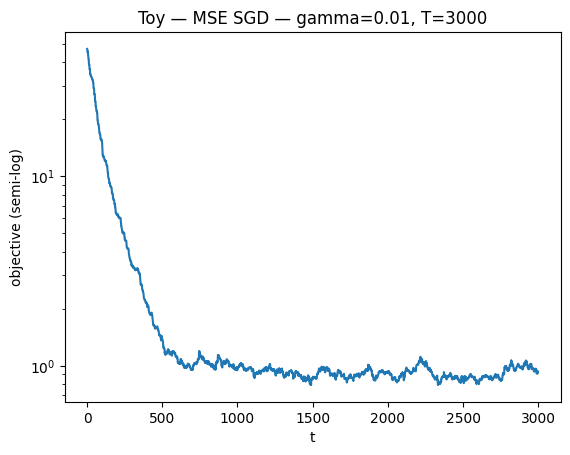

In [136]:
w_toy, all_w_toy, pobj_toy = stochastic_gradient(
    X_toy, y_toy, gamma=gamma, n_iter=n_iter, w_ini=w_ini, loss="mse", alpha=0.0, average=False
)

plt.figure()
plt.semilogy(pobj_toy)
plt.xlabel("t")
plt.ylabel("objective (semi-log)")
plt.title(f"Toy — MSE SGD — gamma={gamma}, T={n_iter}")
plt.show()

With 𝛾 = 0.01 and 𝑇 = 3000, the objective decreases rapidly at the beginning, then stabilizes around a plateau.
This indicates fast initial convergence, followed by stochastic fluctuations around the optimum, which is typical of SGD with a constant step size.

### Q6 - Choice of parameters γ and T

The step size γ and the number of iterations T are chosen based on the
empirical convergence observed in the objective curve (Q5).

In practice:
- a too large γ leads to divergence or strong oscillations,
- a too small γ results in very slow convergence,
- T must be sufficiently large for the objective to stabilize.

In our experiments, γ = 0.01 and T = 3000 provide a satisfactory compromise.


### Q7 - L2 Regularization

We regularize the problem by optimizing instead the objective function

$$
\frac{1}{n}\sum_{i=1}^{n}\ell(\hat{h}_w(x_i), y_i) + \frac{\alpha}{2}\|w\|_2^2,
$$

where $\alpha > 0$ is a regularization parameter.


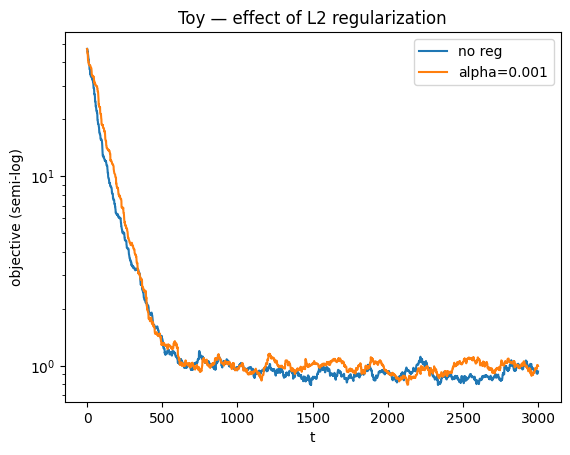

In [ ]:
alpha = 0.001  # adjustable

w_toy_reg, all_w_toy_reg, pobj_toy_reg = stochastic_gradient(
    X_toy, y_toy, gamma=gamma, n_iter=n_iter, w_ini=w_ini, loss="mse", alpha=alpha, average=False
)

plt.figure()
plt.semilogy(pobj_toy, label="no reg")
plt.semilogy(pobj_toy_reg, label=f"alpha={alpha}")
plt.xlabel("t")
plt.ylabel("objective (semi-log)")
plt.title("Toy — effect of L2 regularization")
plt.legend()
plt.show()

L2 regularization slightly slows down the initial decrease of the objective but leads to a more stable convergence, with reduced oscillations compared to the unregularized case.
Both methods converge to a similar objective level, but regularization improves numerical stability and robustness of SGD.

### Q8 - Variable step size

Can we further decrease the objective function by using a non-constant
step size $(\gamma_t)_{t=1,\ldots,T}$ that decreases over the iterations?
If so, what practical issue does this raise?

**Answer:**

Yes, using a decreasing step size can improve convergence by reducing
oscillations near the optimum and yielding a lower final objective value.

Common choices include:
$$
\gamma_t = \frac{\gamma_0}{1 + \alpha t}, \quad
\gamma_t = \frac{\gamma_0}{t}, \quad \text{or} \quad
\gamma_t = \frac{\gamma_0}{\sqrt{t}}.
$$

In our experiments, we adopt the square-root decay
$\gamma_t = \gamma_0 / \sqrt{t+1}$, which provides a simple and widely
used compromise between fast initial progress and stable convergence.

**Advantages:**
- large initial steps enable rapid progress in early iterations,
- decreasing steps reduce oscillations near the optimum.

**Practical issue:**
- additional hyperparameter tuning is required (choice of $\gamma_0$ and
    decay schedule),
- poor choices may lead to premature convergence or slow learning.


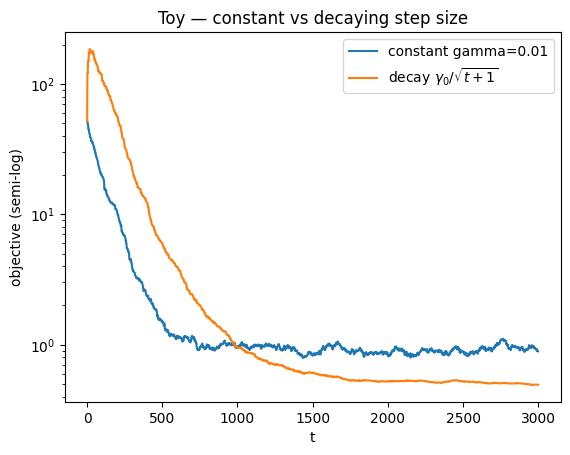

In [126]:
gamma0 = 0.1

def gamma_decay(t):
    return gamma0 / np.sqrt(t + 1)

w_toy_decay, all_w_toy_decay, pobj_toy_decay = stochastic_gradient(
    X_toy, y_toy, gamma=gamma_decay, n_iter=n_iter, w_ini=w_ini, loss="mse", alpha=0.0, average=False
)

plt.figure()
plt.semilogy(pobj_toy, label=f"constant gamma={gamma}")
plt.semilogy(pobj_toy_decay, label=r"decay $\gamma_0/\sqrt{t+1}$")
plt.xlabel("t")
plt.ylabel("objective (semi-log)")
plt.title("Toy — constant vs decaying step size")
plt.legend()
plt.show()

The decaying step size leads to a lower final objective value, as it reduces stochastic fluctuations and allows finer convergence near the optimum.
However, it slows down early convergence and requires careful tuning of the decay schedule, which can be challenging in practice.

## 2. Example on real data

### Q9 - Application to the Iris dataset

We apply the stochastic gradient descent algorithm to the Iris dataset using
the quadratic loss. The goal is to choose a constant step size $\gamma$ and a
number of iterations $T$ that allow us to minimize the objective function and
obtain a correct classification solution.

We propose a constant step size $\gamma = 0.01$ and a number of iterations
$T = 3000$, which empirically lead to a clear decrease of the objective
function and to a correct linear separation of the two classes.

Throughout this question, we consider the quadratic loss
$$
[
\ell(h,y) = \frac{(h-y)^2}{2}.
]
$$


In [145]:
# Load and preprocess Iris dataset (binary)
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[y < 2]
y = y[y < 2].astype(float)
y[y == 0] = -1.0
y[y == 1] = 1.0

X = X[:, :2]  # 2D for visualization

# SGD parameters
gamma = 0.01
n_iter = 3000
w_ini = np.zeros(X.shape[1] + 1)

# Run SGD
w_iris, all_w_iris, pobj_iris = stochastic_gradient(
    X, y, gamma=gamma, n_iter=n_iter, w_ini=w_ini,
    loss="mse", alpha=0.0, average=False
)


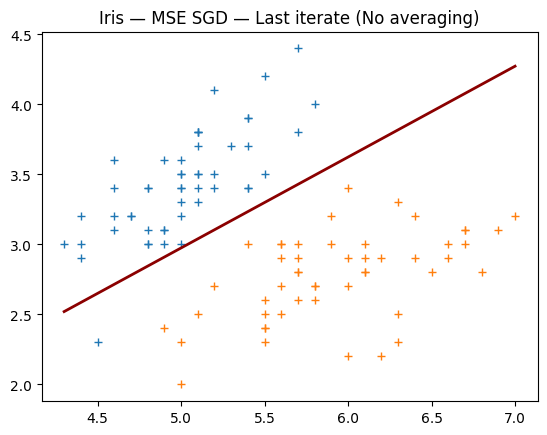

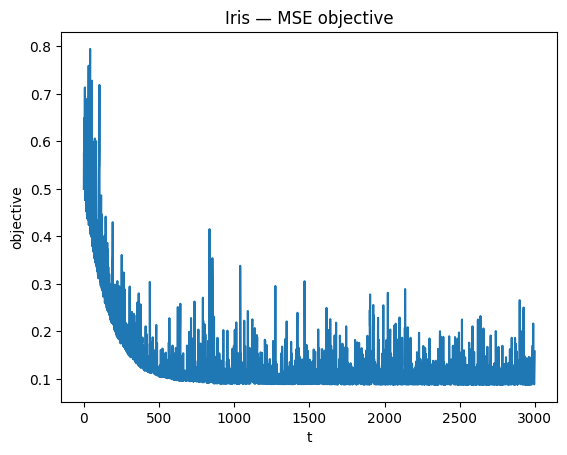

In [154]:
# Decision boundary
plot_2d(
    X, y, w=w_iris,
    title="Iris — MSE SGD — Last iterate (No averaging)",
    line_color="darkred"
)

# Objective evolution
plt.figure()
plt.plot(pobj_iris)
plt.xlabel("t")
plt.ylabel("objective")
plt.title("Iris — MSE objective")
plt.show()


The binary Iris dataset is approximately linearly separable in the selected
feature space, making it suitable for a linear classifier.

Using stochastic gradient descent with a quadratic loss, the learned decision
boundary correctly separates the two classes and is consistent with the data
distribution. Although the quadratic loss is not specifically designed for
classification, it still produces a meaningful linear separator in this case.

The objective function decreases rapidly during the first iterations and then
exhibits persistent oscillations around a minimum value. This behavior is
expected when using SGD with a constant step size, as the stochastic gradient
introduces noise that prevents exact convergence.

### Q10 - Averaged SGD and burn-in $t_0$

We add an optional averaging step to the SGD algorithm and compare the evolution
of the empirical objective function
$$[
J(w) = \frac{1}{n}\sum_{i=1}^{n}\ell(\hat{h}_w(x_i), y_i)
]
$$
as a function of the number of iterations, **with and without averaging**.

The averaged iterate can be updated recursively:
$$[
\bar{w}_{t+1} = \frac{t}{t+1}\bar{w}_t + \frac{1}{t+1}w_{t+1}.
]
$$
We also consider a **burn-in** variant, where averaging starts only after $(t_0)$
iterations:
$$
[
\bar{w}_t = \frac{1}{t-t_0}\sum_{k=t_0+1}^{t} w_k \quad \text{for } t>t_0.
]$$

In the following, we compare:
1. **No averaging** as in Q9 (last iterate $w_t$),
2. **Averaging from the start** ($t_0=0$),
3. **Averaging after burn-in** ($t_0>0$).


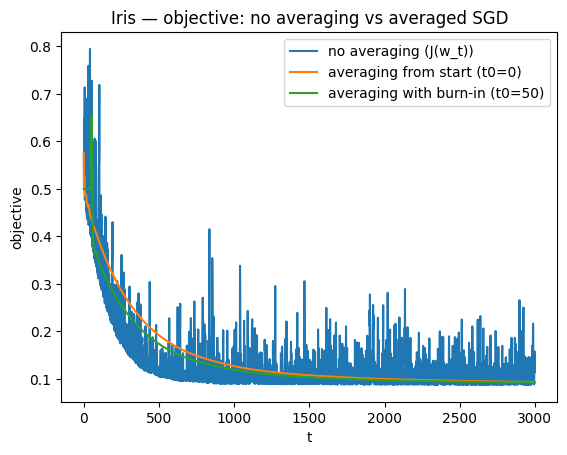

In [167]:
def mse_objective(X, y, w):
    """J(w) = (1/n) sum_i 0.5 ( <w,x_i>-y_i )^2  with bias absorbed via X_aug"""
    X_aug = np.c_[np.ones(X.shape[0]), X]
    return 0.5 * np.mean((y - X_aug @ w) ** 2)

# Baseline objective along SGD iterates (no averaging): J(w_t)
obj_last = np.array([mse_objective(X, y, w) for w in all_w_iris])


def averaged_objective_from_all_w(all_w, t0=0):
    """
    Build the averaged iterates \bar w_t recursively from the stored iterates w_t,
    then return J(\bar w_t) for each t.

    If t0>0: averaging starts at t0 (burn-in). For t < t0, we keep \bar w_t = 0
    (not used) and start meaningful averaging at t0.
    """
    n_iter = all_w.shape[0]
    obj_bar = np.zeros(n_iter)

    w_bar = np.zeros_like(all_w[0])
    count = 0

    for t in range(n_iter):
        if t >= t0:
            count += 1
            w_bar = (1 - 1 / count) * w_bar + (1 / count) * all_w[t]
        obj_bar[t] = mse_objective(X, y, w_bar)

    return obj_bar


# 1) Averaging from the start (t0=0)
obj_avg0 = averaged_objective_from_all_w(all_w_iris, t0=0)

# 2) Averaging after burn-in (t0 > 0)
t0 = 50
obj_avg_t0 = averaged_objective_from_all_w(all_w_iris, t0=t0)

# Plot 
plt.figure()
plt.plot(obj_last, label="no averaging (J(w_t))")
plt.plot(obj_avg0, label="averaging from start (t0=0)")
plt.plot(obj_avg_t0, label=f"averaging with burn-in (t0={t0})")
plt.xlabel("t")
plt.ylabel("objective")
plt.title("Iris — objective: no averaging vs averaged SGD")
plt.legend()
plt.show()

Without averaging, the objective function evaluated at the last iterate
$J(w_t)$ exhibits strong oscillations due to the stochastic nature of the
gradient and the use of a constant step size.

Averaging the iterates significantly reduces the variance of the objective
trajectory. The averaged objective $J(\bar w_t)$ is smoother and stabilizes
around a lower value, which illustrates the variance-reduction effect of
averaged SGD.

Introducing a burn-in period $t_0$ avoids averaging the early, high-bias
iterates and leads to a slightly more stable behavior in the first iterations.
On the Iris dataset, which is relatively well-conditioned and almost linearly
separable, the difference between averaging from the start and averaging after
burn-in remains limited.

### Q11 - L2 regularization

We now regularize the optimization problem by minimizing the following objective:
$
J_\alpha(w) = \frac{1}{n}\sum_{i=1}^{n}\ell(\hat{h}_w(x_i), y_i) + \frac{\alpha}{2}\|w\|_2^2,
\qquad \alpha > 0.
$

Here we keep the quadratic loss $(\ell(h,y)=\frac{(h-y)^2}{2})$ and use the same
SGD procedure as in Q9, but we add the gradient of the regularization term.

We compare the objective evolution for $\alpha=0$ (no regularization) and for a
few positive values of $\alpha$.


In [ ]:
alphas = [0.0, 1e-4, 1e-3, 1e-2]   # adjustable

objs = {}

for a in alphas:
    w_a, all_w_a, _ = stochastic_gradient(
        X, y,
        gamma=gamma,
        n_iter=n_iter,
        w_ini=w_ini,
        loss="mse",
        alpha=a,
        average=False 
    )
    # objective J_alpha(w_t) along iterations
    obj_a = np.array([mse_objective(X, y, w) + 0.5 * a * np.sum(w[1:]**2) for w in all_w_a])
    objs[a] = obj_a

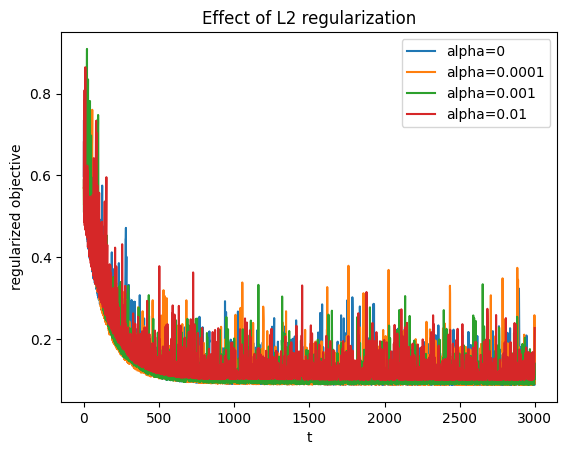

In [186]:
plt.figure()
for a in alphas:
    plt.plot(objs[a], label=f"alpha={a:g}")
plt.xlabel("t")
plt.ylabel("regularized objective")
plt.title("Effect of L2 regularization")
plt.legend()
plt.show()

Introducing an $L_2$ regularization term modifies the objective by penalizing
large weight norms. As a result, the optimized criterion now balances data
fidelity (quadratic loss) and model complexity.

From the figure, we observe that all trajectories converge to a similar region,
but the final value of the regularized objective slightly increases as
$\alpha$ grows. This is expected, since the penalty term
$(\frac{\alpha}{2}\|w\|_2^2)$ contributes positively to the objective.

For small values of $\alpha$, the behavior remains close to the unregularized
case. Larger values of $\alpha$ tend to stabilize the optimization by reducing
the variability of the iterates, at the cost of a slightly higher objective
value.

On this simple and nearly linearly separable Iris dataset, regularization does
not significantly improve performance, but it illustrates the role of $L_2$
penalization in controlling model complexity and improving robustness.


### Q12 - Hinge loss

We now replace the quadratic loss by the hinge loss, defined by
$$
\ell(h,y) = \max(0,\, 1 - y h),
\qquad y \in \{-1,+1\}.
$$

For a linear predictor $(h = w^\top x)$ (bias included), the stochastic gradient
for one sample $((x_i,y_i))$ is:
- if $(y_i,h_i \ge 1)$: the loss is 0 and the subgradient is 0;
- if $(y_i\,h_i < 1)$: the loss is active and a valid subgradient is $(-y_i x_i)$.

When adding $(L_2)$ regularization $(\frac{\alpha}{2}\|w\|_2^2)$, the gradient
becomes:
$$
\nabla f_i(w) = 
\begin{cases}
- y_i x_i + \alpha w & \text{if } y_i h_i < 1,\\
\alpha w & \text{otherwise},
\end{cases}
$$
(with the convention that the bias term is not regularized).


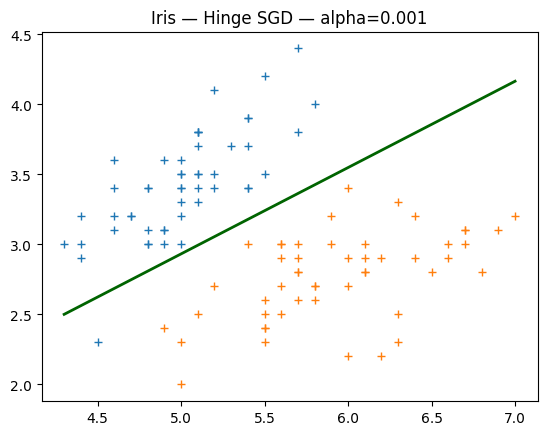

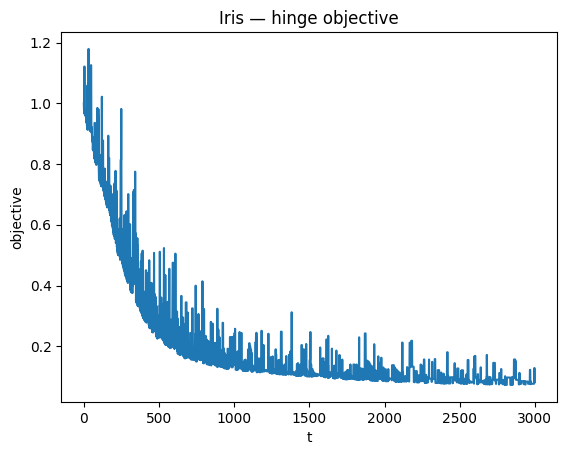

In [ ]:
gamma_h = 0.01
n_iter_h = 3000
alpha_h = 1e-3  

w_ini = np.zeros(X.shape[1] + 1)

w_hinge, all_w_hinge, pobj_hinge = stochastic_gradient(
    X, y,
    gamma=gamma_h,
    n_iter=n_iter_h,
    w_ini=w_ini,
    loss="hinge",
    alpha=alpha_h,
    average=False
)

plot_2d(
    X, y,
    w=w_hinge,
    title=f"Iris — Hinge SGD — alpha={alpha_h}",
    line_color="darkgreen"
)

plt.figure()
plt.plot(pobj_hinge)
plt.xlabel("t")
plt.ylabel("objective")
plt.title("Iris — hinge objective")
plt.show()

The hinge loss is specifically designed for binary classification, as it
penalizes only misclassified samples and correctly classified samples that lie
within the margin $y\,h < 1$. 

Points that are correctly classified with a
sufficient margin $y\,h \ge 1$ do not contribute to the loss and therefore
do not influence the updates.

The learned decision boundary correctly separates the two Iris classes and
maximizes the margin between them, which is consistent with the objective of
hinge-based classifiers.

The objective function decreases rapidly during the first iterations and then
stabilizes with noticeable oscillations. This behavior is expected when using
stochastic gradient descent with a constant step size on a non-smooth loss
function such as the hinge loss.


### Q13 - Comparison with Scikit-Learn

We now compare our implementations with the stochastic optimization algorithms
provided by Scikit-Learn, namely `SGDRegressor` (quadratic loss) and
`SGDClassifier` (hinge loss).

The goal is not to reproduce exactly the same optimization trajectories, but to
verify that the learned decision boundaries and overall behaviors are consistent
with standard implementations.


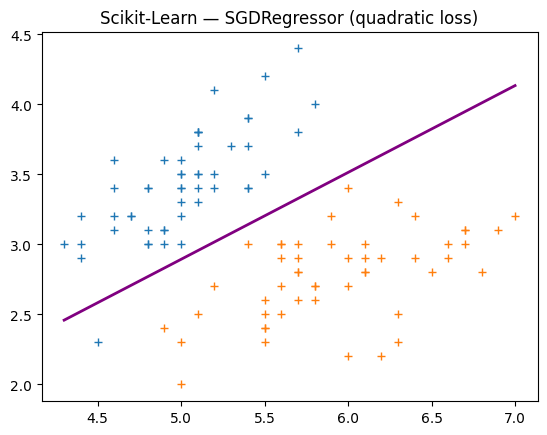

In [210]:
from sklearn.linear_model import SGDRegressor, SGDClassifier

# Quadratic loss
reg = SGDRegressor(
    loss="squared_error",
    penalty="l2",
    alpha=1e-4,
    learning_rate="constant",
    eta0=0.01,
    max_iter=3000,
    tol=1e-6,
    fit_intercept=True,
    random_state=0
)
reg.fit(X, y)

w_sklearn_reg = np.r_[reg.intercept_, reg.coef_]

plot_2d(X, y, w=w_sklearn_reg,
        title="Scikit-Learn — SGDRegressor (quadratic loss)",
        line_color="purple")


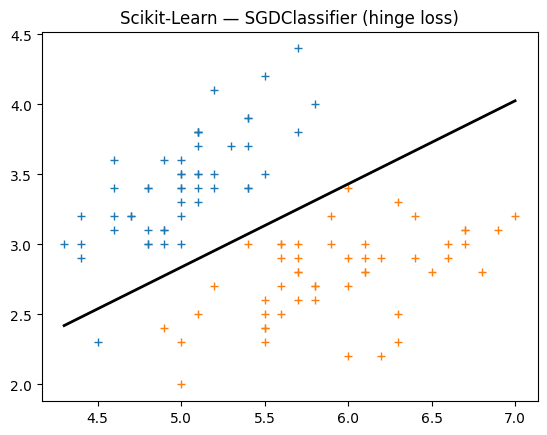

In [211]:
# Hinge loss
clf = SGDClassifier(
    loss="hinge",
    penalty="l2",
    alpha=1e-4,
    learning_rate="constant",
    eta0=0.01,
    max_iter=3000,
    tol=1e-6,
    fit_intercept=True,
    random_state=0
)
clf.fit(X, y)

w_sklearn_clf = np.r_[clf.intercept_, clf.coef_.ravel()]

plot_2d(X, y, w=w_sklearn_clf,
        title="Scikit-Learn — SGDClassifier (hinge loss)",
        line_color="black")


The decision boundaries obtained with Scikit-Learn’s `SGDRegressor`
(quadratic loss) and `SGDClassifier` (hinge loss) are consistent with those
produced by our own stochastic gradient descent implementations.

For the quadratic loss, both methods learn a similar linear separator, even
though this loss is not specifically designed for classification.  
For the hinge loss, the separator obtained with `SGDClassifier` closely matches
the one produced by our hinge-based SGD implementation, reflecting the common
margin-based objective.

Minor differences between the decision boundaries can be explained by different
initializations, internal stopping criteria, and implementation details, but the
overall behavior and orientation of the hyperplanes are similar.

These results validate the correctness of our implementations for both loss
functions.